<a href="https://colab.research.google.com/github/AI-Junction/Titanic/blob/master/Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Introduction

This notebook is a very basic and simple introductory primer to the method of ensembling (combining) 
base learning models, in particular the variant of ensembling known as Stacking. 
In a nutshell stacking uses as a first-level (base), the predictions of a few basic 
classifiers and then uses another model at the second-level to predict the output 
from the earlier first-level predictions.

The Titanic dataset is a prime candidate for introducing this concept as 
many newcomers start out here. Furthermore even though stacking has been 
responsible for many there seems to be a dearth of kernels on this topic 
so I hope this notebook can fill somewhat of that void.
'''


In [1]:
!pip install kaggle

    100% |████████████████████████████████| 61kB 4.1MB/s 
    100% |████████████████████████████████| 245kB 11.4MB/s 
  Running setup.py bdist_wheel for kaggle ... - \ done
  Stored in directory: /root/.cache/pip/wheels/5a/2d/0c/9fc539e558586b9ed9127916a7f4e620163c24cc97460b1188
  Running setup.py bdist_wheel for python-slugify ... - done
  Stored in directory: /root/.cache/pip/wheels/e3/65/da/2045deea3098ed7471eca0e2460cfbd3fdfe8c1d6fa6fcac92
Successfully built kaggle python-slugify


In [2]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])

#filename = "/content/.kaggle/kaggle.json"
#filename = "/.kaggle/kaggle.json"
filename = "kaggle.json"
#os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [3]:
!ls -lha kaggle.json

---x-wx--T 1 root root 65 Dec  7 17:23 kaggle.json


In [4]:
os.path.isdir("/root/.kaggle")

False

In [5]:
dir_kaggle = "/root/.kaggle"
if not os.path.isdir(dir_kaggle):
  !mkdir -p ~/.kaggle  
!cp kaggle.json ~/.kaggle/
os.path.isdir(dir_kaggle)

True

In [0]:
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [8]:
!kaggle competitions files -c Titanic

name                   size  creationDate         
---------------------  ----  -------------------  
train.csv              60KB  2013-06-28 13:40:25  
test.csv               28KB  2013-06-28 13:40:24  
gender_submission.csv   3KB  2017-02-01 01:49:18  


In [10]:
#%%

#load generic packages

import sys #access to system parameters https://docs.python.org/3/library/sys.html
print("Python version: {}". format(sys.version))

import pandas as pd #collection of functions for data processing and analysis modeled after R dataframes with SQL like features
print("pandas version: {}". format(pd.__version__))

import matplotlib #collection of functions for scientific and publication-ready visualization
print("matplotlib version: {}". format(matplotlib.__version__))

import numpy as np #foundational package for scientific computing
print("NumPy version: {}". format(np.__version__))

import scipy as sp #collection of functions for scientific computing and advance mathematics
print("SciPy version: {}". format(sp.__version__)) 

import IPython
from IPython import display #pretty printing of dataframes in Jupyter notebook
print("IPython version: {}". format(IPython.__version__)) 

import sklearn #collection of machine learning algorithms
print("scikit-learn version: {}". format(sklearn.__version__))

#misc libraries
import random
import time


#ignore warnings
import warnings
warnings.filterwarnings('ignore')
print('-'*25)



# Load in our libraries

import re
import matplotlib.pyplot as plt


#import plotly.offline as py
#py.init_notebook_mode(connected=True)
#import plotly.graph_objs as go
#import plotly.tools as tls
#import warnings
#import xgboost as xgb
#import seaborn as sns
#%matplotlib inline


#%%



Python version: 3.6.7 (default, Oct 22 2018, 11:32:17) 
[GCC 8.2.0]
pandas version: 0.22.0
matplotlib version: 2.1.2
NumPy version: 1.14.6
SciPy version: 1.1.0
IPython version: 5.5.0
scikit-learn version: 0.19.2
-------------------------


In [0]:
#load classification models

# Going to use these 5 base models for the stacking

from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.cross_validation import KFold




In [26]:
#%%

# load data from local files
dsb_data_dir = 'drive/My Drive/Machine Learning/All ML Datasets'
label = 'titanic'

file_path_train = os.path.join(dsb_data_dir,'{}_train.csv'.format(label))
file_path_test = os.path.join(dsb_data_dir,'{}_test.csv'.format(label))


train = pd.read_csv(file_path_train)
test = pd.read_csv(file_path_test)

train.shape
test.shape

train.columns.values
test.columns



Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [27]:
#Which features are mixed data types?


train.info()
test.info()

train.describe()
test.describe()

train.describe(include=[np.object])
train.describe(include=[np.number])
#train.describe(include=['Ticket'])


train['Fare'].isnull().sum()





<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float

0

In [28]:
#%%

'''
Assumtions based on data analysis

We arrive at following assumptions based on data analysis done so far. We 
may validate these assumptions further before taking appropriate actions.

Correlating.

We want to know how well does each feature correlate with Survival. 
We want to do this early in our project and match these quick correlations with 
modelled correlations later in the project.

Completing.

    We may want to complete Age feature as it is definitely correlated to survival.
    We may want to complete the Embarked feature as it may also correlate with survival or 
    another important feature.

Correcting.

    Ticket feature may be dropped from our analysis as it contains high ratio of duplicates 
    (22%) and there may not be a correlation between Ticket and survival.
    Cabin feature may be dropped as it is highly incomplete or contains many null values 
    both in training and test dataset.
    PassengerId may be dropped from training dataset as it does not contribute to survival.
    Name feature is relatively non-standard, may not contribute directly to survival, so maybe dropped.

Creating.

    We may want to create a new feature called Family based on Parch and SibSp 
    to get total count of family members on board.
    We may want to engineer the Name feature to extract Title as a new feature.
    We may want to create new feature for Age bands. This turns a continous numerical 
    feature into an ordinal categorical feature.
    We may also want to create a Fare range feature if it helps our analysis.

Classifying.

We may also add to our assumptions based on the problem description noted earlier.

    Women (Sex=female) were more likely to have survived.
    Children (Age<?) were more likely to have survived.
    The upper-class passengers (Pclass=1) were more likely to have survived.

'''




#%%

'''
Analyze by pivoting features

To confirm some of our observations and assumptions, we can quickly analyze our feature correlations by pivoting features against each other. We can only do so at this stage for features which do not have any empty values. It also makes sense doing so only for features which are categorical (Sex), ordinal (Pclass) or discrete (SibSp, Parch) type.

    Pclass We observe significant correlation (>0.5) among Pclass=1 and Survived (classifying #3). We decide to include this feature in our model.
    Sex We confirm the observation during problem definition that Sex=female had very high survival rate at 74% (classifying #1).
    SibSp and Parch These features have zero correlation for certain values. It may be best to derive a feature or a set of features from these individual features (creating #1).

'''


train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)
train[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)
train[["SibSp", "Survived"]].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)
train[["Parch", "Survived"]].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)







,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


In [0]:

#%%

'''
Feature Exploration, Engineering and Cleaning

Now we will proceed much like how most kernels in general are structured, 
and that is to first explore the data on hand, identify possible feature 
engineering opportunities as well as numerically encode any categorical features.
'''



# Store our passenger ID for easy access

PassengerId = test['PassengerId']

train.head(3)

full_data = [train, test]

# Some features of my own that I have added in

# Gives the length of the name

train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)

# Feature that tells whether a passenger had a cabin on the Titanic

train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

# Feature engineering steps taken from Sina

# Create new feature FamilySize as a combination of SibSp and Parch

for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

# Create new feature IsAlone from FamilySize

for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

# Remove all NULLS in the Embarked column

for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')

# Remove all NULLS in the Fare column and create a new feature CategoricalFare

for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())




In [0]:
#%%

#train['CategoricalFare'] = pd.qcut(train['Fare'], 4)

#train['CategoricalFare'][:3]

# Create a New feature CategoricalAge

for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)





In [31]:


train['CategoricalAge'] = pd.cut(train['Age'], 5)

print(train['CategoricalAge'][:5])

# Define function to extract titles from passenger names

def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)

    # If the title exists, extract and return it.

    if title_search:
        return title_search.group(1)

    return ""

# Create a new feature Title, containing the titles of passenger names

for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)

print(train['Title'].unique())

# Group all non-common titles into one single grouping "Rare"

for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')



0    (16.0, 32.0]
1    (32.0, 48.0]
2    (16.0, 32.0]
3    (32.0, 48.0]
4    (32.0, 48.0]
Name: CategoricalAge, dtype: category
Categories (5, interval[float64]): [(-0.08, 16.0] < (16.0, 32.0] < (32.0, 48.0] < (48.0, 64.0] <
                                    (64.0, 80.0]]
['Mr' 'Mrs' 'Miss' 'Master' 'Don' 'Rev' 'Dr' 'Mme' 'Ms' 'Major' 'Lady'
 'Sir' 'Mlle' 'Col' 'Capt' 'Countess' 'Jonkheer']


In [0]:


for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)

    # Mapping titles
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare']                               = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare']                                  = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age']                          = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4 ;



In [33]:
# Feature selection

drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge'], axis = 1)
test  = test.drop(drop_elements, axis = 1)

train.shape
test.shape
train.columns
test.columns

train.head()

train.dtypes
test.dtypes

for col in train.columns:
    print(train[col].dtype)

train_columns_dtype = train.dtypes.reset_index()
train_columns_dtype.columns = ['col', 'type']
train_columns_dtype_grouped = train_columns_dtype.groupby('type').aggregate('count').reset_index()
print(train_columns_dtype_grouped)

train.shape
test.shape

print(train.columns)
print(test.columns)




int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
    type  col
0  int64   12
Index(['Survived', 'Pclass', 'Sex', 'Age', 'Parch', 'Fare', 'Embarked',
       'Name_length', 'Has_Cabin', 'FamilySize', 'IsAlone', 'Title'],
      dtype='object')
Index(['Pclass', 'Sex', 'Age', 'Parch', 'Fare', 'Embarked', 'Name_length',
       'Has_Cabin', 'FamilySize', 'IsAlone', 'Title'],
      dtype='object')


In [34]:
#%%

#Compare survival rates

pd.crosstab(train['Title'], train['Sex'])
train[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean()
train[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

train['Fare'].isnull().sum()


print(train.columns.values)

for x in train.columns.values:
    if train[x].dtype != 'float64' :
        if x != 'Survived' :
            print('Survival Correlation by:', x)
            print(train[[x, 'Survived']].groupby(x, as_index=False).mean())
            print('-'*10, '\n')






['Survived' 'Pclass' 'Sex' 'Age' 'Parch' 'Fare' 'Embarked' 'Name_length'
 'Has_Cabin' 'FamilySize' 'IsAlone' 'Title']
Survival Correlation by: Pclass
   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363
---------- 

Survival Correlation by: Sex
   Sex  Survived
0    0  0.742038
1    1  0.188908
---------- 

Survival Correlation by: Age
   Age  Survived
0    0  0.563636
1    1  0.346939
2    2  0.369231
3    3  0.434783
4    4  0.090909
---------- 

Survival Correlation by: Parch
   Parch  Survived
0      0  0.343658
1      1  0.550847
2      2  0.500000
3      3  0.600000
4      4  0.000000
5      5  0.200000
6      6  0.000000
---------- 

Survival Correlation by: Fare
   Fare  Survived
0     0  0.197309
1     1  0.308756
2     2  0.445415
3     3  0.581081
---------- 

Survival Correlation by: Embarked
   Embarked  Survived
0         0  0.339009
1         1  0.553571
2         2  0.389610
---------- 

Survival Correlation by: Name_length
    Name_length  Su

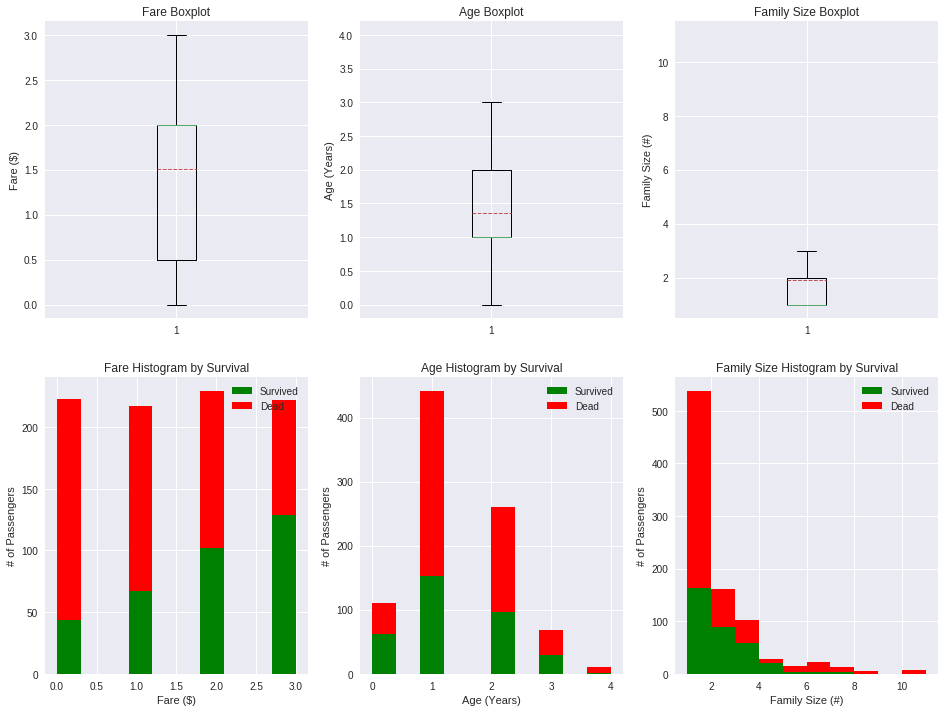

In [35]:

plt.figure(figsize=[16,12])

plt.subplot(231)
plt.boxplot(x=train['Fare'], showmeans = True, meanline = True)
plt.title('Fare Boxplot')
plt.ylabel('Fare ($)')

plt.subplot(232)
plt.boxplot(train['Age'], showmeans = True, meanline = True)
plt.title('Age Boxplot')
plt.ylabel('Age (Years)')

plt.subplot(233)
plt.boxplot(train['FamilySize'], showmeans = True, meanline = True)
plt.title('Family Size Boxplot')
plt.ylabel('Family Size (#)')

plt.subplot(234)
plt.hist(x = [train[train['Survived']==1]['Fare'], train[train['Survived']==0]['Fare']], 
         stacked=True, color = ['g','r'],label = ['Survived','Dead'])
plt.title('Fare Histogram by Survival')
plt.xlabel('Fare ($)')
plt.ylabel('# of Passengers')
plt.legend()

plt.subplot(235)
plt.hist(x = [train[train['Survived']==1]['Age'], train[train['Survived']==0]['Age']], 
         stacked=True, color = ['g','r'],label = ['Survived','Dead'])
plt.title('Age Histogram by Survival')
plt.xlabel('Age (Years)')
plt.ylabel('# of Passengers')
plt.legend()


plt.subplot(236)
plt.hist(x = [train[train['Survived']==1]['FamilySize'], train[train['Survived']==0]['FamilySize']], 
         stacked=True, color = ['g','r'],label = ['Survived','Dead'])
plt.title('Family Size Histogram by Survival')
plt.xlabel('Family Size (#)')
plt.ylabel('# of Passengers')
plt.legend()





"\nTakeaway from the Plots\n\nOne thing that that the Pearson Correlation plot can tell us is that \nthere are not too many features strongly correlated with one another. \nThis is good from a point of view of feeding these features into your \nlearning model because this means that there isn't much redundant or \nsuperfluous data in our training set and we are happy that each feature \ncarries with it some unique information. Here are two most correlated \nfeatures are that of Family size and Parch (Parents and Children). I'll \nstill leave both features in for the purposes of this exercise.\n\n"

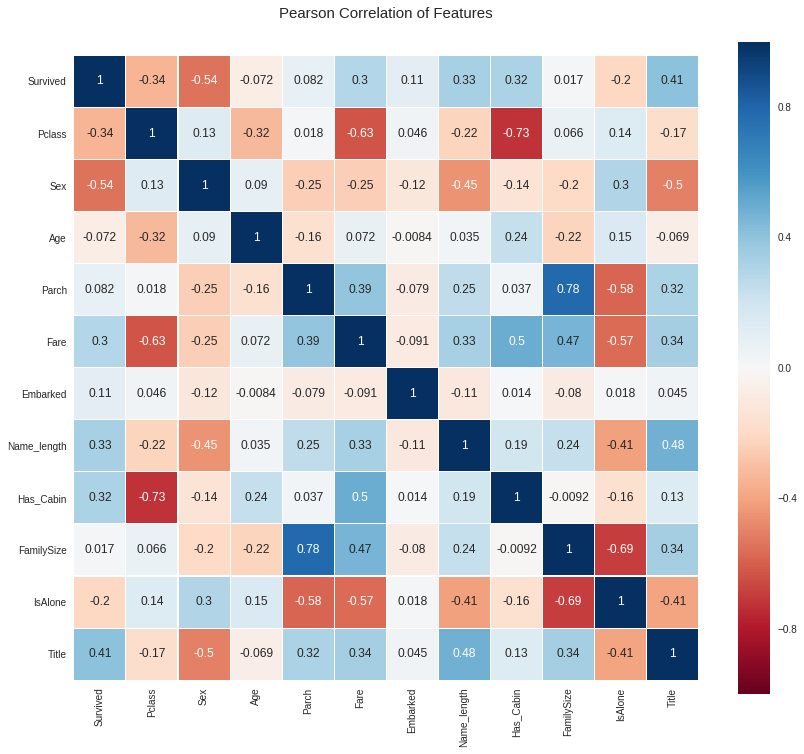

In [37]:
import seaborn as sns



'''
All right so now having cleaned the features and extracted relevant information and dropped the categorical columns our features should now all be numeric, a format suitable to feed into our Machine Learning models. However before we proceed let us generate some simple correlation and distribution plots of our transformed dataset to observe ho
Visualisations
'''

train.head(3)

train.astype(float).corr()



'''
Pearson Correlation Heatmap



let us generate some correlation plots of the features to see how 
related one feature is to the next. To do so, we will utilise the 
Seaborn plotting package which allows us to plot heatmaps very 
conveniently as follows
'''

colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

'''
Takeaway from the Plots

One thing that that the Pearson Correlation plot can tell us is that 
there are not too many features strongly correlated with one another. 
This is good from a point of view of feeding these features into your 
learning model because this means that there isn't much redundant or 
superfluous data in our training set and we are happy that each feature 
carries with it some unique information. Here are two most correlated 
features are that of Family size and Parch (Parents and Children). I'll 
still leave both features in for the purposes of this exercise.

'''


In [0]:


from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier




In [39]:

X_train = train.drop("Survived", axis=1)
Y_train = train["Survived"]
X_test = test

X_train.shape, Y_train.shape, X_test.shape

X_train.columns
X_test.columns


# Logistic Regression

logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
acc_log




81.71

In [40]:

'''
Next we model using Support Vector Machines which are supervised learning models 
with associated learning algorithms that analyze data used for classification and 
regression analysis. Given a set of training samples, each marked as belonging to 
one or the other of two categories, an SVM training algorithm builds a model that 
assigns new test samples to one category or the other, making it a 
non-probabilistic binary linear classifier. Reference Wikipedia.

Note that the model generates a confidence score which is higher than 
Logistics Regression model.
'''


# Support Vector Machines

svc = SVC()
svc.fit(X_train, Y_train)
Y_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_train, Y_train) * 100, 2)
acc_svc



86.76

In [41]:

'''
In pattern recognition, the k-Nearest Neighbors algorithm (or k-NN 
for short) is a non-parametric method used for classification 
and regression. A sample is classified by a majority vote of 
its neighbors, with the sample being assigned to the class 
most common among its k nearest neighbors (k is a positive 
integer, typically small). If k = 1, then the object is 
simply assigned to the class of that single nearest neighbor. 
Reference Wikipedia.

KNN confidence score is better than Logistics Regression 
but worse than SVM.
'''

knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train, Y_train) * 100, 2)
acc_knn



87.88

In [42]:
'''
In machine learning, naive Bayes classifiers are a family of 
simple probabilistic classifiers based on applying Bayes' theorem with 
strong (naive) independence assumptions between the features. 
Naive Bayes classifiers are highly scalable, requiring a 
number of parameters linear in the number of variables (features) 
in a learning problem. Reference Wikipedia.

The model generated confidence score is the lowest 
among the models evaluated so far.
'''

# Gaussian Naive Bayes

gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)
Y_pred = gaussian.predict(X_test)
acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)
acc_gaussian



79.69

In [43]:

'''
The perceptron is an algorithm for supervised learning 
of binary classifiers (functions that can decide whether 
an input, represented by a vector of numbers, belongs 
to some specific class or not). It is a type of linear 
classifier, i.e. a classification algorithm that makes 
its predictions based on a linear predictor function 
combining a set of weights with the feature vector. 
The algorithm allows for online learning, in that it 
processes elements in the training set one at a time. 
Reference Wikipedia.

# Perceptron
'''

perceptron = Perceptron()
perceptron.fit(X_train, Y_train)
Y_pred = perceptron.predict(X_test)
acc_perceptron = round(perceptron.score(X_train, Y_train) * 100, 2)
acc_perceptron



81.37

In [44]:

# Linear SVC

linear_svc = LinearSVC()
linear_svc.fit(X_train, Y_train)
Y_pred = linear_svc.predict(X_test)
acc_linear_svc = round(linear_svc.score(X_train, Y_train) * 100, 2)
acc_linear_svc



81.59

In [45]:

# Stochastic Gradient Descent

sgd = SGDClassifier()
sgd.fit(X_train, Y_train)
Y_pred = sgd.predict(X_test)
acc_sgd = round(sgd.score(X_train, Y_train) * 100, 2)
acc_sgd



80.13

In [46]:
'''
This model uses a decision tree as a predictive model which 
maps features (tree branches) to conclusions about the target 
value (tree leaves). Tree models where the target variable 
can take a finite set of values are called classification 
trees; in these tree structures, leaves represent class labels 
and branches represent conjunctions of features that lead to 
those class labels. Decision trees where the target variable 
can take continuous values (typically real numbers) are 
called regression trees. Reference Wikipedia.

The model confidence score is the highest among models 
evaluated so far.
'''

# Decision Tree

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
acc_decision_tree



96.63

In [47]:

'''
The next model Random Forests is one of the most popular. 
Random forests or random decision forests are an ensemble 
learning method for classification, regression and other tasks, 
that operate by constructing a multitude of decision trees (n_estimators=100) 
at training time and outputting the class that is the mode 
of the classes (classification) or mean prediction (regression) 
of the individual trees. Reference Wikipedia.

The model confidence score is the highest among models evaluated 
so far. We decide to use this model's output (Y_pred) for 
creating our competition submission of results.

# Random Forest
'''

random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
acc_random_forest




96.52

In [48]:
#Model evaluation

'''
We can now rank our evaluation of all the models to choose 
the best one for our problem. While both Decision Tree and 
Random Forest score the same, we choose to use Random Forest 
as they correct for decision trees' habit of overfitting to 
their training set.
'''


models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree'],
    'Score': [acc_svc, acc_knn, acc_log, 
              acc_random_forest, acc_gaussian, acc_perceptron, 
              acc_sgd, acc_linear_svc, acc_decision_tree]})
models.sort_values(by='Score', ascending=False)


,Model,Score
8,Decision Tree,96.63
3,Random Forest,96.52
1,KNN,87.88
0,Support Vector Machines,86.76
2,Logistic Regression,81.71
7,Linear SVC,81.59
5,Perceptron,81.37
6,Stochastic Gradient Decent,80.13
4,Naive Bayes,79.69
